In [1]:
# Statistical Arbitrage - Pair Trading Strategy
import pandas as pd
import numpy as np
from binance.client import Client # pip install python-binance
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor
import math
import os.path
import time
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

In [ ]:
# client login to binance.us
binance_client = Client(os.getenv('binance_api'), os.getenv('binance_secret'))
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

In [ ]:
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '../statarb/data/%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df= pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    for line in klines:
        del line[6:]
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data['symbol'] = symbol
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [ ]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
# saves all files in /data directory
binance_symbols = []
tickers = binance_client.get_all_tickers()
for item in tickers:
        binance_symbols.append(item['symbol'])
for symbol in binance_symbols:
    get_all_binance(symbol, '1d', save = True)

In [ ]:
globbed_files = glob.glob("../statarb/data/*.csv") #creates a list of all csv files

data = [] # pd.concat takes a list of dataframes as an agrument
for csv in globbed_files:
    frame = pd.read_csv(csv)
    data.append(frame)

combined_data = pd.concat(data, ignore_index=True) #dont want pandas to try an align row indexes
combined_data.to_csv('combined_data.csv', index=False, encoding='utf-8-sig') #export to csv

In [2]:
df = pd.read_csv('combined_data.csv')
df.set_index('timestamp', inplace=True)
df = df[['symbol', 'close', 'volume']]
df = df[df['symbol'].str.contains("USDT")]

start_date = '2020-10-01'
end_date = '2021-02-04'

mask = (df.index > start_date) & (df.index <= end_date)
df = df.loc[mask]
limit = len(df[df['symbol'] == 'ETHUSDT'])
counts = df['symbol'].value_counts()
df = df[~df['symbol'].isin(counts[counts < limit].index)]

by_volume = df.groupby('symbol')['volume'].mean().nlargest(50)
by_volume = (by_volume.index).tolist()
df = df[df['symbol'].isin(by_volume)]
df = df[['symbol', 'close']]

In [3]:
df = df.pivot_table(index='timestamp', columns='symbol', values='close')
#df = df[df['ETHUSDT'].notna()]
df.head()

symbol      ADAUSDT  ANKRUSDT  ARPAUSDT   BTTUSDT  BUSDUSDT  CELRUSDT  \
timestamp                                                               
2020-10-02  0.09286  0.007285   0.02153  0.000332    0.9999   0.00478   
2020-10-03  0.09328  0.007298   0.02153  0.000330    0.9998   0.00474   
2020-10-04  0.09686  0.007243   0.02183  0.000330    0.9998   0.00469   
2020-10-05  0.09738  0.007084   0.02148  0.000329    0.9998   0.00463   
2020-10-06  0.09289  0.005916   0.01790  0.000311    1.0003   0.00395   

symbol       CHZUSDT  COSUSDT  COTIUSDT  CVCUSDT  ...  TROYUSDT  TRXUSDT  \
timestamp                                         ...                      
2020-10-02  0.010611  0.00742   0.03423  0.02507  ...  0.002960  0.02590   
2020-10-03  0.010795  0.00745   0.03440  0.02506  ...  0.002989  0.02719   
2020-10-04  0.011000  0.00743   0.03484  0.02537  ...  0.002944  0.02644   
2020-10-05  0.011013  0.00744   0.03747  0.02503  ...  0.002921  0.02643   
2020-10-06  0.010346  0.00715   0.02992  0.02285  ...  0.002802  0.02556   

symbol      USDCUSDT   VETUSDT  VTHOUSDT   WINUSDT  XLMUSDT  XRPDOWNUSDT  \
timestamp                                                                  
2020-10-02    0.9998  0.011859  0.000697  0.000080  0.07096       10.835   
2020-10-03    0.9997  0.011739  0.000715  0.000083  0.07100       10.923   
2020-10-04    0.9998  0.011657  0.000700  0.000083  0.07290        9.441   
2020-10-05    0.9999  0.011383  0.000680  0.000083  0.07331        9.081   
2020-10-06    1.0001  0.010106  0.000622  0.000080  0.07237        9.600   

symbol      XRPUSDT  ZILUSDT  
timestamp                     
2020-10-02  0.23386  0.01802  
2020-10-03  0.23273  0.01857  
2020-10-04  0.24794  0.02129  
2020-10-05  0.25030  0.02070  
2020-10-06  0.24545  0.01818  

[5 rows x 50 columns]

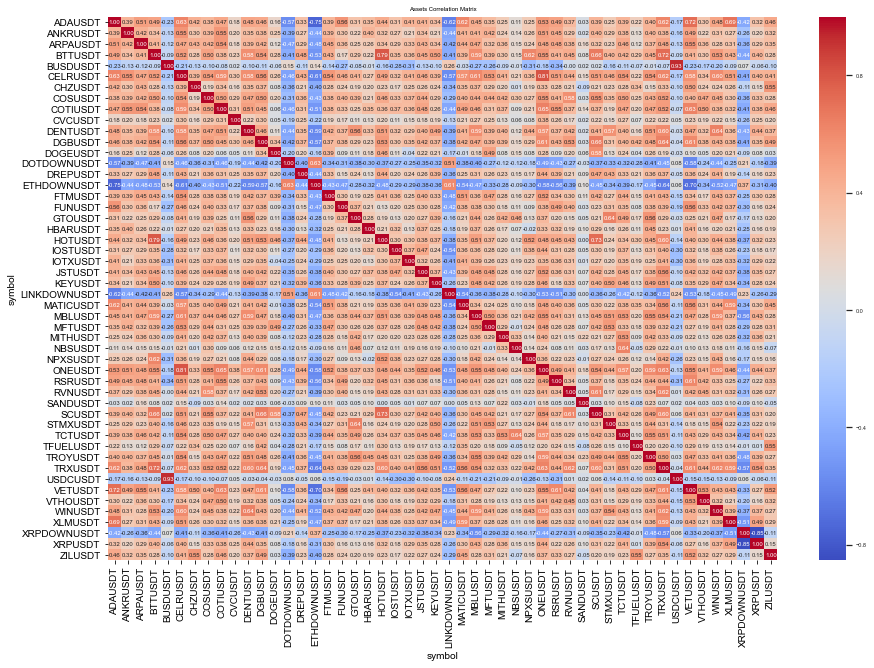

In [4]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(15,10))
sns.set(font_scale=0.5)
sns.heatmap(df.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=300, bbox_inches='tight')

[('ADAUSDT', 'NPXSUSDT'), ('ANKRUSDT', 'DENTUSDT'), ('ANKRUSDT', 'DOGEUSDT'), ('ANKRUSDT', 'FUNUSDT'), ('ANKRUSDT', 'IOTXUSDT'), ('ANKRUSDT', 'MFTUSDT'), ('ANKRUSDT', 'ONEUSDT'), ('ANKRUSDT', 'RVNUSDT'), ('ANKRUSDT', 'SANDUSDT'), ('ANKRUSDT', 'SCUSDT'), ('ANKRUSDT', 'STMXUSDT'), ('ANKRUSDT', 'TCTUSDT'), ('ARPAUSDT', 'CELRUSDT'), ('ARPAUSDT', 'COTIUSDT'), ('ARPAUSDT', 'CVCUSDT'), ('ARPAUSDT', 'GTOUSDT'), ('ARPAUSDT', 'RVNUSDT'), ('ARPAUSDT', 'SCUSDT'), ('ARPAUSDT', 'TRXUSDT'), ('ARPAUSDT', 'VTHOUSDT'), ('ARPAUSDT', 'XLMUSDT'), ('ARPAUSDT', 'XRPDOWNUSDT'), ('BTTUSDT', 'CELRUSDT'), ('BTTUSDT', 'COSUSDT'), ('BTTUSDT', 'DENTUSDT'), ('BTTUSDT', 'FTMUSDT'), ('BTTUSDT', 'FUNUSDT'), ('BTTUSDT', 'HBARUSDT'), ('BTTUSDT', 'IOSTUSDT'), ('BTTUSDT', 'MATICUSDT'), ('BTTUSDT', 'NPXSUSDT'), ('BTTUSDT', 'RVNUSDT'), ('BTTUSDT', 'SANDUSDT'), ('BTTUSDT', 'SCUSDT'), ('BTTUSDT', 'STMXUSDT'), ('BTTUSDT', 'VETUSDT'), ('BTTUSDT', 'VTHOUSDT'), ('BUSDUSDT', 'CELRUSDT'), ('BUSDUSDT', 'CHZUSDT'), ('BUSDUSDT', 'COSUS

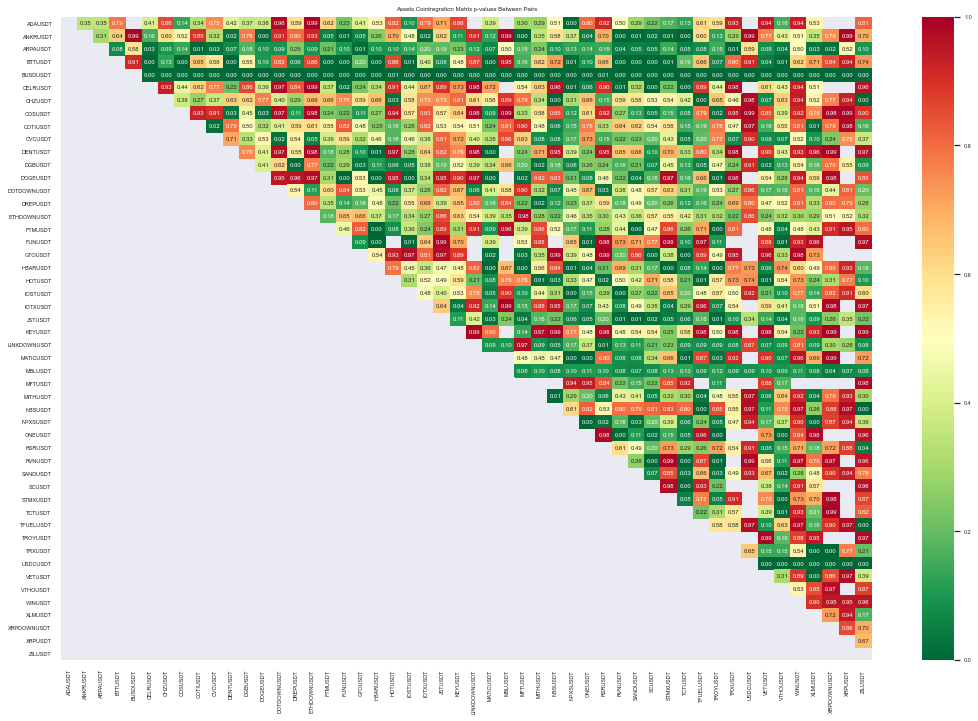

In [5]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(df)
print(pairs)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pvalues, xticklabels = df.columns,
                yticklabels = df.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=300, bbox_inches='tight')

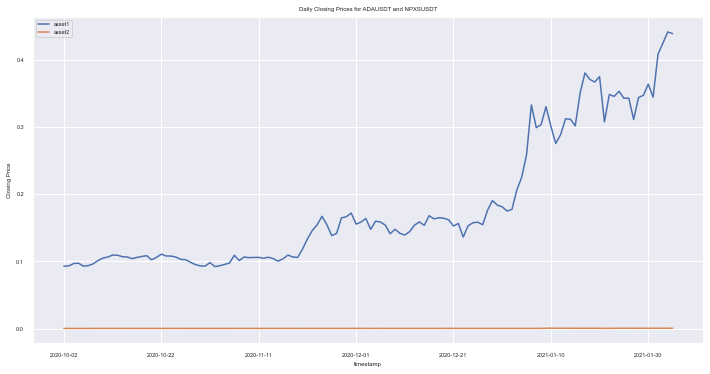

In [6]:
# final pair to test strategy
asset1 = 'ADAUSDT'
asset2 = 'NPXSUSDT'

# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = df[asset1]
train['asset2'] = df[asset2]

# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
plt.savefig('chart3', dpi=300)

In [7]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

Hedge Ratio =  0.0011767878182249445


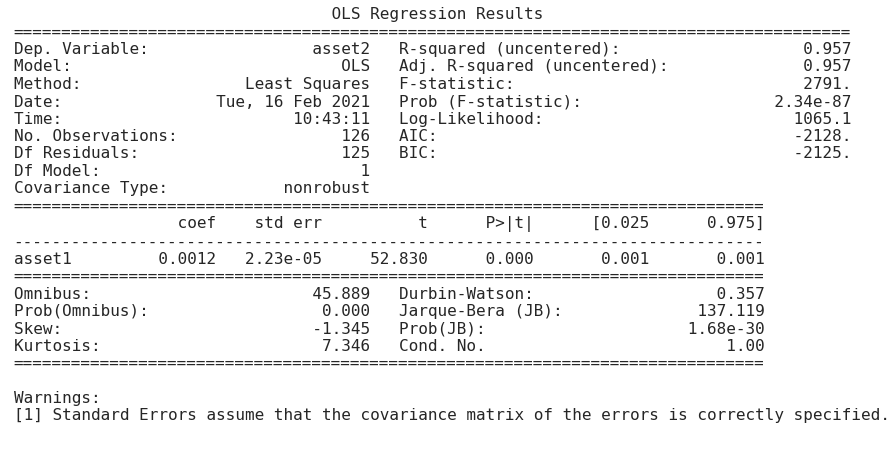

In [8]:
# print regression summary results
plt.rc('figure', figsize=(15,10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=300);
print('Hedge Ratio = ', model.params[0])

Critical Value =  -4.365426716058228
{'1%': -3.484219653271961, '5%': -2.885145235641637, '10%': -2.579359138917794}


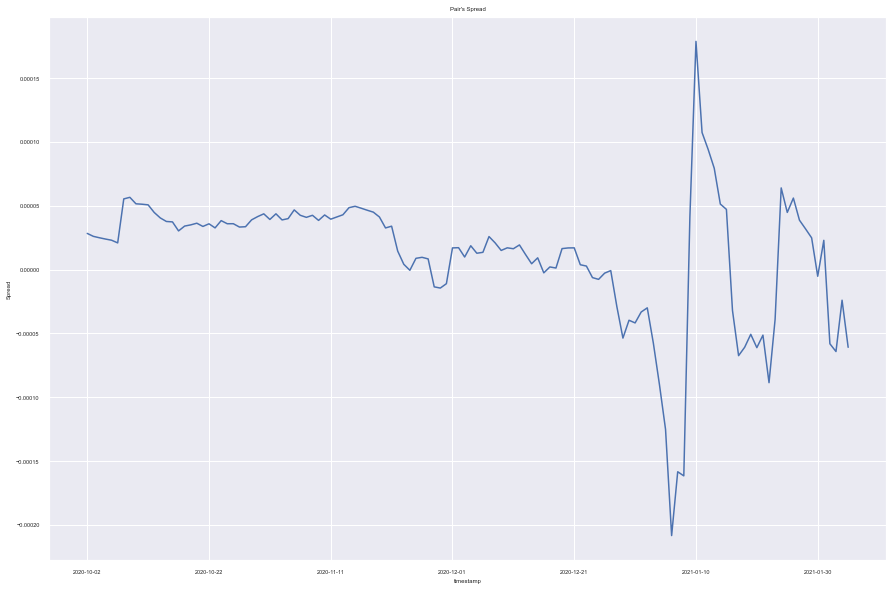

In [9]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

# Plot the spread
ax = spread.plot(figsize=(15,10), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

# probablity critical values
print(adf[4])

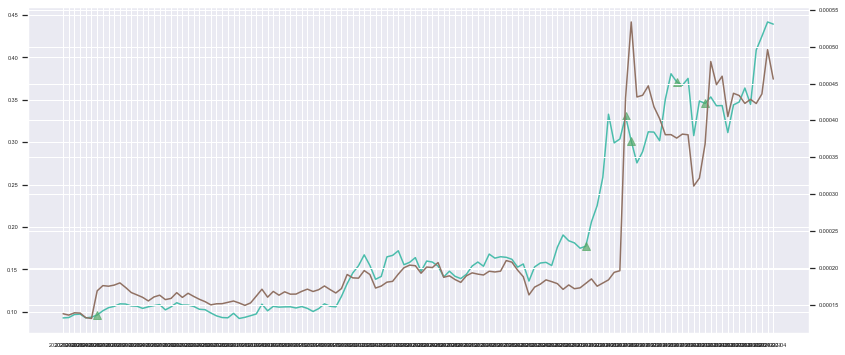

In [12]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = df[asset1] 
signals['asset2'] = df[asset2]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# verify datafame head and tail
signals.head(3).append(signals.tail(3))

# visualize trading signals and position
fig=plt.figure(figsize=(15,10))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

In [13]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

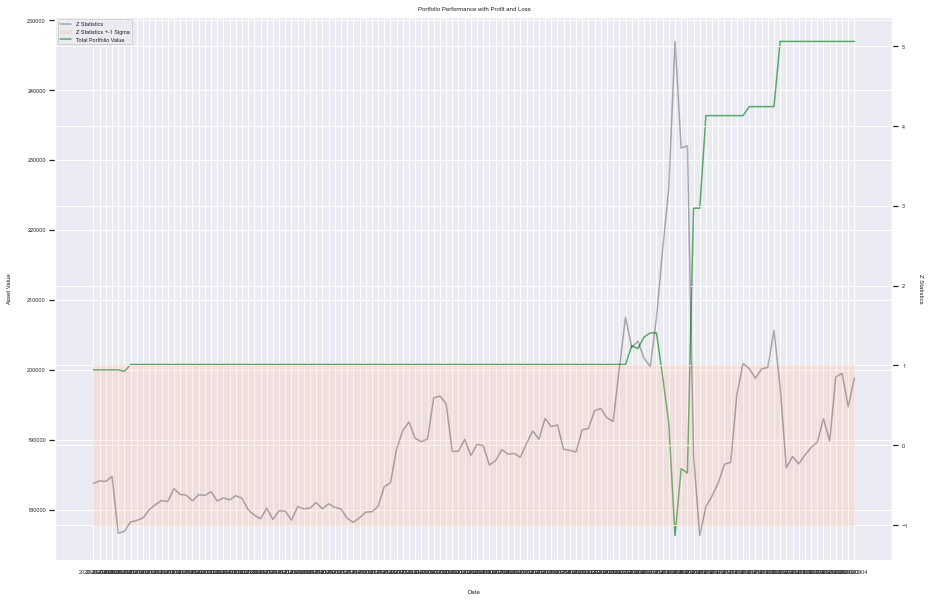

In [14]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(15,10),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=300);

In [15]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

TypeError: unsupported operand type(s) for -: 'str' and 'str'